### Random Acts of Pizza

#### By:  David Skarbrevik, Jayashree Raman, and Nikki Haas
#### Data Science w207:  Intro to Machine Learning
#### University of California, Berkeley
#### Spring, 2017

In [77]:
#some of the SKLearn features we learnt in class are being depreciated.  They still exist for now, so let's ignore 
#the watnings
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)

warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=RuntimeWarning)

#General Libraries
import re
import numpy as np
import matplotlib.pyplot as plt
import nltk
import json
import pandas as pd
import os
import xgboost as xgb
import datetime
from subprocess import check_output
from matplotlib import pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.mixture import GMM
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MaxAbsScaler

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

#SkLearn construction items
from scipy.sparse.csr import csr_matrix
from scipy.sparse import hstack


%matplotlib inline
import sys
print(sys.version)

3.5.2 |Anaconda 4.1.1 (x86_64)| (default, Jul  2 2016, 17:52:12) 
[GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)]


#### Customized Features

Will the time of day, week, or year help determine which requests results in pizza?

In [78]:
def day_time(x):
    y = ''
    if datetime.datetime.fromtimestamp(x['unix_timestamp_of_request_utc']).hour < 10:
        y = 'morning'
    elif datetime.datetime.fromtimestamp(x['unix_timestamp_of_request_utc']).hour >= 10 and datetime.datetime.fromtimestamp(x['unix_timestamp_of_request_utc']).hour < 16:
        y = 'midday'
    elif datetime.datetime.fromtimestamp(x['unix_timestamp_of_request_utc']).hour >= 16 and datetime.datetime.fromtimestamp(x['unix_timestamp_of_request_utc']).hour < 21:
        y = 'evening'
    else: 
        y = 'late_night'
    return y

day_values = ['morning', 'midday', 'evening', 'late_night']
    
def human_time(a):
    import datetime
    from datetime import date
    import calendar
    ### for the data in raop, return human time.  maybe the time of day matters
    a['human_readable_local_time'] = datetime.datetime.fromtimestamp(a['unix_timestamp_of_request']).strftime('%Y-%m-%d %H:%M:%S')
    a['human_readable_UTC_time'] = datetime.datetime.fromtimestamp(a['unix_timestamp_of_request_utc']).strftime('%Y-%m-%d %H:%M:%S')
    a['weekday'] = calendar.day_name[datetime.datetime.fromtimestamp(a['unix_timestamp_of_request']).weekday()].lower()
    a['month'] = datetime.datetime.fromtimestamp(a['unix_timestamp_of_request']).strftime("%B").lower()
    a['time_of_day'] = day_time(a)
    return a

a = pd.read_json('train.json')
b = a.apply(human_time, axis=1)
c = pd.read_json('test.json')
d = c.apply(human_time, axis =1)

#### Binarized Model

Take all the categorical data, binarize it, and use PCA to find the most relevant categories

In [79]:
#parse the training set to match the testing set's columns
df = b[list(d.columns)]
tstdf = d[list(d.columns)]

In [80]:
#items to binarize:
# all categorical
# requester_subreddits_at_request
# weekday
# month
# time_of_day

#add-ons:
#make bins for numeric cols to coerece into categorical
# requester_account_age_in_days_at_request
# requester_days_since_first_post_on_raop_at_request
# requester_number_of_comments_at_request
# requester_number_of_comments_in_raop_at_request
# requester_number_of_posts_at_request
# requester_number_of_posts_on_raop_at_request
# requester_number_of_subreddits_at_request
# requester_upvotes_minus_downvotes_at_request
# requester_upvotes_plus_downvotes_at_request

In [81]:
b = pd.get_dummies(df['weekday'])
tstb = pd.get_dummies(tstdf['weekday'])
c = pd.get_dummies(df['time_of_day'])
tstc = pd.get_dummies(tstdf['time_of_day'])
d= pd.get_dummies(df['month'])
tstd= pd.get_dummies(tstdf['month'])
df2 = pd.concat([df,b,c,d], axis=1)
tstdf2 = pd.concat([tstdf,tstb,tstc,tstd], axis=1)

In [82]:
del df2['month']
del tstdf2['month']
del df2['weekday']
del tstdf2['weekday']
del df2['time_of_day']
del tstdf2['time_of_day']

In [83]:
subr = []
for x in df['requester_subreddits_at_request']:
    for i, t in enumerate(x):
            subr.append(t)
subr = set(subr)

tstsubr = []
for x in tstdf['requester_subreddits_at_request']:
    for i, t in enumerate(x):
            tstsubr.append(t)
tstsubr = set(tstsubr)


In [84]:
df4 = pd.get_dummies(df2['requester_subreddits_at_request'].apply(pd.Series), prefix='', prefix_sep='').sum(level=0, axis=1)
tstdf4 = pd.get_dummies(tstdf2['requester_subreddits_at_request'].apply(pd.Series), prefix='', prefix_sep='').sum(level=0, axis=1)



df2 = df2[[ 'request_id','friday',
       'monday', 'saturday', 'sunday', 'thursday', 'tuesday', 'wednesday',
       'evening', 'late_night', 'midday', 'morning', 'april', 'august',
       'december', 'february', 'january', 'july', 'june', 'march', 'may',
       'november', 'october', 'september']]
tstdf2 = tstdf2[[ 'request_id','friday',
       'monday', 'saturday', 'sunday', 'thursday', 'tuesday', 'wednesday',
       'evening', 'late_night', 'midday', 'morning', 'april', 'august',
       'december', 'february', 'january', 'july', 'june', 'march', 'may',
       'november', 'october', 'september']]

df5 = pd.concat([a['requester_received_pizza'],df2,df4], axis = 1)
tstdf5 = pd.concat([tstdf2,tstdf4], axis = 1)

In [85]:
### Save the work for ease of use

In [86]:
df5.to_json('binarized_categorical_data.json')
tstdf5.to_json('binarized_categorical_test_data.json')


In [87]:
df6 = pd.read_json('binarized_categorical_data.json')
tstdf6 = pd.read_json('binarized_categorical_test_data.json')
del df6['request_id']
del tstdf6['request_id']

Divide the Binarized Categorical Data - Train into Train and Dev datasets - We will use the Dev dataset for testing the accuracy of the prediction

In [88]:
df6_labels = df6['requester_received_pizza']
del df6['requester_received_pizza']
df6_data = df6

bincat_train_data = df6_data[0:2019]
bincat_train_labels = df6_labels[0:2019]
bincat_test_data = df6_data[2020:]
bincat_test_labels = df6_labels[2020:]

We run a series of experiments to find the model that gives the best accuracy with no more than 50 parameters.

In [89]:
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=RuntimeWarning)

def calc_param(n_features, n_components, covtype, classes):
## Function to compute the total parameters for model
   if covtype == 'full': #Covariance Parameters (n_components, n_features, n_features) Symmetric matrix
        totparam = (n_features*n_components + (n_features*(n_features+1)/2)*n_components)*classes
   elif covtype == 'diag': #Covariance Parameters (n_components, n_features)    
        totparam = (n_features*n_components + n_features*n_components)*classes
   elif covtype == 'spherical': #Covariance Parameters = (n_components,)
        totparam = (n_features*n_components + 1)*classes
   elif covtype == 'tied': #Covariance Parameters (n_features, n_features)  Symmetric matrix
        totparam = (n_features*n_components + (n_features*(n_features+1)/2))*classes
   else:
      print('Invalid Covariance Type %s'%(covtype))
    
   return totparam

def P6():
### STUDENT START ###
    cov_matrix = ['spherical', 'diag', 'tied', 'full'] #Initialize list of covariance types 
    modelnum = 0 #Initialize model number
#Loop through to run a series of experiments to find the model that gives the best accuracy with no more than 50 parameters
    for comp in range(1,8): #Vary the Principal components between 1 and 8
        #Project the train data onto the reduced Principal component subspace
        sklearn_pca = PCA(n_components=comp)
        sklearn_transf = sklearn_pca.fit_transform(bincat_train_data)
        #Divide the projected data into positive and negative class datasets
        positive_train_data = sklearn_transf[bincat_train_labels == True]
        negative_train_data = sklearn_transf[bincat_train_labels == False]
        
        for GMMcomp in range(1,8): #Vary the Gaussian Mixture model components between 1 and 8
           for covtype in cov_matrix: #Loop thru the 4 covariance types for the PCA and GMM components
            totparam = calc_param(comp, GMMcomp, covtype, 2) #Calculate the total parameters for model
            modelnum += 1 #Increment the model number
            if totparam <= 50: #Validate that the total parameters for model is <= 50
            #Train the GMM positive and negative models on the positive and negative datasets respectively
                   gm_mod_pos = GMM(n_components = GMMcomp, covariance_type=covtype)
                   gm_mod_pos.fit(positive_train_data)
                   gm_mod_neg = GMM(n_components = GMMcomp, covariance_type=covtype)
                   gm_mod_neg.fit(negative_train_data)
            #Score the trained model on the test dataset
                   sklearn_test_transf = sklearn_pca.transform(bincat_test_data)
                   pscore = gm_mod_pos.score(sklearn_test_transf)
                   nscore = gm_mod_neg.score(sklearn_test_transf)
           
            #Loop to determine the predicted labels of the test data based on the trained model
                   preds = []
                   for pos, neg in zip(pscore, nscore):
                        if pos > neg: preds.append(1)
                        else: preds.append(0)
            
            #Loop to compare the predicted label with the actual label to determine the no of correct answers
                   correct = 0
                   for pred, label in zip(preds, bincat_test_labels):
                        if pred == label: correct +=1
            #Calculate and print the accuracy of the model
                   print('%d Parameters %d PCA Comp %d GMM Comp %d Cov Matrix %s Accuracy is\t %.2f%%'% (modelnum, totparam, comp, GMMcomp, covtype, (100.0*correct/len(bincat_test_labels))))
            else: #If total parameters > 50 skip
                   print('%d Parameters %d PCA Comp %d GMM Comp %d Cov Matrix %s exceeds 50 params'% (modelnum, totparam, comp, GMMcomp, covtype))

            
### STUDENT END ###

P6()

1 Parameters 4 PCA Comp 1 GMM Comp 1 Cov Matrix spherical Accuracy is	 52.08%
2 Parameters 4 PCA Comp 1 GMM Comp 1 Cov Matrix diag Accuracy is	 52.08%
3 Parameters 4 PCA Comp 1 GMM Comp 1 Cov Matrix tied Accuracy is	 52.08%
4 Parameters 4 PCA Comp 1 GMM Comp 1 Cov Matrix full Accuracy is	 52.08%
5 Parameters 6 PCA Comp 1 GMM Comp 2 Cov Matrix spherical Accuracy is	 43.07%
6 Parameters 8 PCA Comp 1 GMM Comp 2 Cov Matrix diag Accuracy is	 43.07%
7 Parameters 6 PCA Comp 1 GMM Comp 2 Cov Matrix tied Accuracy is	 51.73%
8 Parameters 8 PCA Comp 1 GMM Comp 2 Cov Matrix full Accuracy is	 43.07%
9 Parameters 8 PCA Comp 1 GMM Comp 3 Cov Matrix spherical Accuracy is	 50.00%
10 Parameters 12 PCA Comp 1 GMM Comp 3 Cov Matrix diag Accuracy is	 50.00%
11 Parameters 8 PCA Comp 1 GMM Comp 3 Cov Matrix tied Accuracy is	 56.24%
12 Parameters 12 PCA Comp 1 GMM Comp 3 Cov Matrix full Accuracy is	 50.64%
13 Parameters 10 PCA Comp 1 GMM Comp 4 Cov Matrix spherical Accuracy is	 48.76%
14 Parameters 16 PCA Com

Best accuracy for this model is given by:

Parameters 18 PCA Comp 3 GMM Comp 1 Cov Matrix tied Accuracy is	 65.84%

Parameters 18 PCA Comp 3 GMM Comp 1 Cov Matrix full Accuracy is	 65.84%

In [90]:
pca = PCA(n_components=10)
pca.fit_transform(bincat_train_data)
ind = ['PC-1','PC-2','PC-3','PC-4','PC-5','PC-6','PC-7','PC-8','PC-9','PC-10']

# Dump components relations with features:

pca_df = pd.DataFrame(pca.components_,columns=bincat_train_data.columns,index = ind)



best_cat_cols = pca_df.idxmax(axis=1)

print(best_cat_cols)

PC-1                     pics
PC-2                  evening
PC-3               reddit.com
PC-4     Random_Acts_Of_Pizza
PC-5     Random_Acts_Of_Pizza
PC-6                  morning
PC-7                    trees
PC-8                    trees
PC-9                   gaming
PC-10               wednesday
dtype: object


In [91]:
type(best_cat_cols)

pandas.core.series.Series

In [92]:
best_cat_cols = list(set(list(best_cat_cols)))

In [93]:
best_cat_cols

['Random_Acts_Of_Pizza',
 'evening',
 'pics',
 'trees',
 'wednesday',
 'gaming',
 'morning',
 'reddit.com']

In [94]:
clf2 = RandomForestClassifier(n_estimators=12)
clf2.fit(bincat_train_data, bincat_train_labels)

preds2 = clf2.predict(bincat_test_data)

print(classification_report(bincat_test_labels,preds2))

print(metrics.accuracy_score(bincat_test_labels,preds2))

             precision    recall  f1-score   support

      False       0.75      0.95      0.84      1519
       True       0.27      0.06      0.09       501

avg / total       0.63      0.73      0.66      2020

0.728712871287


#### Numeric Model

Take all the numeric data, and build a numeric model

In [115]:
 # setup the training and development data
cols = ['requester_account_age_in_days_at_request',
       'requester_days_since_first_post_on_raop_at_request',
       'requester_number_of_comments_at_request',
       'requester_number_of_comments_in_raop_at_request',
       'requester_number_of_posts_at_request',
       'requester_number_of_posts_on_raop_at_request',
       'requester_number_of_subreddits_at_request','requester_upvotes_minus_downvotes_at_request',
       'requester_upvotes_plus_downvotes_at_request']
full_train_data = pd.read_json('train.json', orient='columns')
test_data = pd.read_json('test.json', orient='columns')
train_labels = full_train_data['requester_received_pizza']
num_data = full_train_data[cols]

text_data = train_data.iloc[:,6]


# some posts have crazy high vote counts
#np.sort(train_data.iloc[:,26])[:-11:-1]

# indices of all numeric variables
all_count_num_vars = [1,2,5,9,10,11,12,13,14,15,16,17,18,19,20,21,24,25,26,27]

# only "at time of request" numeric variables
count_num_vars_at_request = [1,2,5,9,11,13,15,17,19,21,24,26]

#for x,y in enumerate(train_data.columns):
#    print(x,y)

#for j in [1,5,6,60,600,659,3000]:
#    for i in all_count_num_vars:
#        print(train_data[j,i])

#np.unique(train_data.iloc[:,25])

#train_data['bin_votes'] = bin_votes

#np.max(train_data.iloc[:,26])/1000

np.random.seed(1)




# Preparing train/test data
#num_data = train_data.iloc[:,all_count_num_vars]
num_labels = train_labels



# randomizing the data
#shuffle = np.random.permutation(np.arange(num_data.shape[0]))
#num_train_data, num_train_labels = num_data[shuffle], num_labels[shuffle]

#num_train_data = num_data[:3000,]
#num_train_labels = num_labels[:3000]

#num_test_data = num_data[3001:,]
#num_test_labels = num_labels[3001:]


num_train_data = num_data[0:2019]
num_train_labels = num_labels[0:2019]
num_test_data = num_data[2020:]
num_test_labels = num_labels[2020:]


# simple logistic regression model
lf = LogisticRegression(C = 100)
lf.fit(num_train_data, num_train_labels)

preds = lf.predict(num_test_data)

print(classification_report(num_test_labels,preds))

print(metrics.accuracy_score(num_test_labels,preds))


             precision    recall  f1-score   support

      False       0.76      0.99      0.86      1532
       True       0.69      0.04      0.07       488

avg / total       0.75      0.76      0.67      2020

0.763366336634


In [116]:
### Let's try a Random Forest Classifier
lf2 = RandomForestClassifier(n_estimators=12)
lf2.fit(num_train_data, num_train_labels)

preds2 = lf2.predict(num_test_data)
#preds = lf2.predict(X_test_json)
print(classification_report(num_test_labels,preds2))

print(metrics.accuracy_score(num_test_labels,preds2))

             precision    recall  f1-score   support

      False       0.76      0.92      0.83      1532
       True       0.28      0.10      0.15       488

avg / total       0.65      0.72      0.67      2020

0.719801980198


In [117]:
#### experiment with xgboost
gbm = xgb.XGBClassifier()
gbm.fit(num_train_data, num_train_labels)
preds3 = gbm.predict(num_test_data)

print(classification_report(num_test_labels,preds3))

print(metrics.accuracy_score(num_test_labels,preds3))


             precision    recall  f1-score   support

      False       0.77      0.98      0.86      1532
       True       0.48      0.06      0.11       488

avg / total       0.70      0.76      0.68      2020

0.757425742574


In [118]:
### Pull in text data
a = pd.read_json('train.json', orient='columns')
data_set = a[['request_text_edit_aware','request_title']]

data_labels = a['requester_received_pizza']

def preprocess(x):
    """Use a series of regex expressions to remove unwanted characters"""
    #remove non-alpha-numeric characters, replace with whitespace
    x1 = re.sub(r'[^a-zA-Z_0-9_\s]'," ", x).lower()
    #replae all numbers with a single token and a space afterwards
    x1a = re.sub(r'[0-9]+', 'number ', x1)
    #x1b = re.sub(r'[_]+', ' ', x1a)
    #even though there are words that are just '_____', f1 actuall decreases when they're removed
    #remove newlines
    x2 = re.sub(r'[\n]', " ", x1a)
    #scrub out extra spaces
    x3 = re.sub(r'\s+', ' ', x2)  #other steps might have added extra space; remove
    return x3.strip()

sss = StratifiedShuffleSplit(test_size=0.25, random_state=1)
for train_index, test_index in sss.split(data_set, data_labels):
    X_train, X_test = data_set.iloc[train_index], data_set.iloc[test_index]
    y_train, y_test = data_labels.iloc[train_index], data_labels.iloc[test_index]


from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion


class ItemSelector(BaseEstimator, TransformerMixin):
    """For data grouped by feature, select subset of data at a provided key.

    The data is expected to be stored in a 2D data structure, where the first
    index is over features and the second is over samples.  i.e.

    >> len(data[key]) == n_samples

    Please note that this is the opposite convention to scikit-learn feature
    matrixes (where the first index corresponds to sample).

    ItemSelector only requires that the collection implement getitem
    (data[key]).  Examples include: a dict of lists, 2D numpy array, Pandas
    DataFrame, numpy record array, etc.

    >> data = {'a': [1, 5, 2, 5, 2, 8],
               'b': [9, 4, 1, 4, 1, 3]}
    >> ds = ItemSelector(key='a')
    >> data['a'] == ds.transform(data)

    ItemSelector is not designed to handle data grouped by sample.  (e.g. a
    list of dicts).  If your data is structured this way, consider a
    transformer along the lines of `sklearn.feature_extraction.DictVectorizer`.

    Parameters
    ----------
    key : hashable, required
        The key corresponding to the desired value in a mappable.
    """
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]


class TextStats(BaseEstimator, TransformerMixin):
    """Extract features from each document for DictVectorizer"""

    def fit(self, x, y=None):
        return self

    def transform(self, posts):
        return [{'length': len(text),
                 'num_sentences': text.count('.')}
                for text in posts]


class SubjectBodyExtractor(BaseEstimator, TransformerMixin):
    """Extract the subject & body from a usenet post in a single pass.

    Takes a sequence of strings and produces a dict of sequences.  Keys are
    `subject` and `body`.
    """
    def fit(self, x, y=None):
        return self

    def transform(self, posts):
        features = np.recarray(shape=(len(posts),),
                               dtype=[('subject', object), ('body', object)])
        for i, text in enumerate(posts):
            headers, _, bod = text.partition('\n\n')
            bod = strip_newsgroup_footer(bod)
            bod = strip_newsgroup_quoting(bod)
            features['body'][i] = bod

            prefix = 'Subject:'
            sub = ''
            for line in headers.split('\n'):
                if line.startswith(prefix):
                    sub = line[len(prefix):]
                    break
            features['subject'][i] = sub

        return features


pipeline = Pipeline([
    # Extract the subject & body
    #('subjectbody', SubjectBodyExtractor()),

    # Use FeatureUnion to combine the features from subject and body
    ('union', FeatureUnion(
        transformer_list=[

            # Pipeline for pulling features from the post's subject line
            ('get-title', Pipeline([
                ('selector', ItemSelector(key='request_title')),
                ('cv', TfidfVectorizer(analyzer='char_wb', 
                                       #vocabulary=vocabulary,
                                       preprocessor=preprocess,
                                       max_df=0.5, ngram_range=(1,3)))
            ])),

            # Pipeline for standard bag-of-words model for body
            ('get-request', Pipeline([
                ('selector', ItemSelector(key='request_text_edit_aware')),
                ('cv', TfidfVectorizer(analyzer='char_wb', 
                                       #vocabulary=vocabulary,
                                       preprocessor=preprocess,
                                       max_df=0.5, ngram_range=(1,3)))
            ])),
            
           #('get-number', Pipeline([
           #     ('selector', ItemSelector(key='number'))
           # ]))

        ]
    )),

    # Use a SVC classifier on the combined features
    ('nb',LogisticRegression(penalty='l2',C=100)),
])


pipeline.fit(X_train, y_train)
text_pred = pipeline.predict(X_test)
target_names = [ 'No pizza','Got pizza']
print(classification_report(y_test, text_pred, target_names=target_names))


             precision    recall  f1-score   support

   No pizza       0.76      0.81      0.78       762
  Got pizza       0.27      0.22      0.24       248

avg / total       0.64      0.66      0.65      1010



In [98]:
#from http://scikit-learn.org/stable/auto_examples/hetero_feature_union.html
#try the Pipeline implementation from sk learn

import numpy as np
from sklearn.preprocessing import OneHotEncoder

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.datasets import fetch_20newsgroups
#from sklearn.datasets.twenty_newsgroups import strip_newsgroup_footer
#from sklearn.datasets.twenty_newsgroups import strip_newsgroup_quoting
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier)


class ItemSelector(BaseEstimator, TransformerMixin):
    """For data grouped by feature, select subset of data at a provided key.

    The data is expected to be stored in a 2D data structure, where the first
    index is over features and the second is over samples.  i.e.

    >> len(data[key]) == n_samples

    Please note that this is the opposite convention to scikit-learn feature
    matrixes (where the first index corresponds to sample).

    ItemSelector only requires that the collection implement getitem
    (data[key]).  Examples include: a dict of lists, 2D numpy array, Pandas
    DataFrame, numpy record array, etc.

    >> data = {'a': [1, 5, 2, 5, 2, 8],
               'b': [9, 4, 1, 4, 1, 3]}
    >> ds = ItemSelector(key='a')
    >> data['a'] == ds.transform(data)

    ItemSelector is not designed to handle data grouped by sample.  (e.g. a
    list of dicts).  If your data is structured this way, consider a
    transformer along the lines of `sklearn.feature_extraction.DictVectorizer`.

    Parameters
    ----------
    key : hashable, required
        The key corresponding to the desired value in a mappable.
    """
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]


class WeekdayExtractor(BaseEstimator, TransformerMixin):
    """Extract features from each document for DictVectorizer"""
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        shape = data_dict.shape
        return data_dict[self.key].reshape(shape[0],1)

class SubjectBodyExtractor(BaseEstimator, TransformerMixin):
    """Extract the subject & body from a usenet post in a single pass.

    Takes a sequence of strings and produces a dict of sequences.  Keys are
    `subject` and `body`.
    """
    def fit(self, x, y=None):
        return self

    def transform(self, posts):
        features = np.recarray(shape=(len(posts),),
                               dtype=[('subject', object), ('body', object)])
        for i, text in enumerate(posts):
            headers, _, bod = text.partition('\n\n')
            bod = strip_newsgroup_footer(bod)
            bod = strip_newsgroup_quoting(bod)
            features['body'][i] = bod

            prefix = 'Subject:'
            sub = ''
            for line in headers.split('\n'):
                if line.startswith(prefix):
                    sub = line[len(prefix):]
                    break
            features['subject'][i] = sub

        return features

class NBWrapper(BaseEstimator, TransformerMixin):
    """Extract features from each document for DictVectorizer"""
    def __init__(self, NB):
        self.NB = NB

    def fit(self, x, y=None):
        self.NB.fit(x, y)
        return self

    def transform(self, posts):
        return self.NB.predict(posts)

pipeline4= Pipeline([
    # Extract the subject & body
    #('subjectbody', SubjectBodyExtractor()),

    # Use FeatureUnion to combine the features from subject and body
    ('union', FeatureUnion(
        transformer_list=[
        ### add in text variables
            # Pipeline for pulling features from the post's subject line
            ('get-title', Pipeline([
                ('selector', ItemSelector(key='request_title')),
           #     ('cv', CountVectorizer(analyzer='char_wb', 
           #                           #vocabulary=vocabulary,
           #                            #preprocessor=preprocess,
           #                          max_df=0.5, ngram_range=(1,2))),
                ('tfidf', TfidfVectorizer(min_df=65, 
                                          preprocessor=preprocess,
                                          max_df=0.5, ngram_range=(1,3)
                                         ))
            ])),

            # Pipeline for standard bag-of-words model for body
            #('get-request', Pipeline([
            #    ('selector', ItemSelector(key='weekday')),
            #    ('cv', DictVectorizer( 
            #                           #vocabulary=vocabulary,
            #                           ))
            #])),
            
            ('get-text', Pipeline([
                ('selector', ItemSelector(key='request_text_edit_aware')),
                ('tfidf', TfidfVectorizer(min_df=50,
                                          preprocessor=preprocess,
                                          max_df=0.5, ngram_range=(1,3)
                                         ))
                #('cv', CountVectorizer(analyzer='char_wb', 
                #                       #vocabulary=vocabulary,
                #                       max_df=0.5, ngram_range=(1,3)))
            ]))

        

        ]
    )),

    # Use a SVC classifier on the combined features
    #('estimator',LogisticRegression(penalty='l2',C=25))
    #('estimator', SVC(kernel='linear')) 
    ('estimator', DecisionTreeClassifier())
    #('estimator', RandomForestClassifier())
    #('estimator', MultinomialNB())
    #('estmator', KNeighborsClassifier())
])

pipeline4.fit(X_train, y_train)
text_pred = pipeline4.predict(X_test)
target_names = [ 'No pizza','Got pizza']
print(classification_report(y_test, text_pred, target_names=target_names))

             precision    recall  f1-score   support

   No pizza       0.77      0.76      0.76       762
  Got pizza       0.29      0.31      0.30       248

avg / total       0.65      0.65      0.65      1010



#### Single Data Type Models

It appears that for a single type of data (categorical, numeric, text), the numeric data with a random forest model performs the best.  The next question is, can we combine model types to make a stronger model?

A data scientist at SAP/Concur suggested that we should do each task separately, then combine the data together for one model, using Logistic Regression.

In [119]:
### data needed:
#binarized categorical data: df6_data 
#numeric data: num_data
#numeric data cannot be used as is.  
#Take num_data and normalize all fields
#text data:  data_set
#text data's pipeline masks some of the data, let's redo the Tf-Idf vectorization

In [120]:
#numeric
cols = ['requester_account_age_in_days_at_request',
       'requester_days_since_first_post_on_raop_at_request',
       'requester_number_of_comments_at_request',
       'requester_number_of_comments_in_raop_at_request',
       'requester_number_of_posts_at_request',
       'requester_number_of_posts_on_raop_at_request',
       'requester_number_of_subreddits_at_request','requester_upvotes_minus_downvotes_at_request',
       'requester_upvotes_plus_downvotes_at_request']
scl = MaxAbsScaler()
num_norm = pd.DataFrame(index=num_data.index)
for col in cols:
    scl.fit(num_data[col].values.reshape(-1,1))
    c = col+'_scaled'
    num_norm[c] = scl.transform(num_data[col].values.reshape(-1, 1))

In [121]:
#text
tkn_request = TfidfVectorizer(preprocessor=preprocess,stop_words='english')
tkn_title = TfidfVectorizer(preprocessor=preprocess,stop_words='english')
feature_request = tkn_request.fit_transform(data_set['request_text_edit_aware'])
feature_title = tkn_title.fit_transform(data_set['request_title'])

In [122]:
#stack the text features
text_X = hstack((feature_request, feature_title), format='csr')
#text_X = hstack((feature_title), format='csr')

In [123]:
# Transform dense matrices to sparse formats so that they can be concatenated
X = hstack((text_X,
            csr_matrix(df6_data), 
            csr_matrix(num_norm)), 
           format='csr')

In [124]:
y = df6_labels

In [125]:
sss = StratifiedShuffleSplit(test_size=0.33, random_state=1)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [126]:
sss = StratifiedShuffleSplit(test_size=0.33, random_state=1)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
target_names = [ 'No pizza','Got pizza']
print(classification_report(y_test, y_pred, target_names=target_names))

             precision    recall  f1-score   support

   No pizza       0.77      0.93      0.84      1021
  Got pizza       0.33      0.12      0.17       313

avg / total       0.67      0.74      0.69      1334



In [127]:
model1 = LogisticRegression()
model1.fit(X, y)
y_pred = model1.predict(X)
print(classification_report(y, y_pred, target_names=target_names))

             precision    recall  f1-score   support

   No pizza       0.91      1.00      0.95      3046
  Got pizza       0.99      0.69      0.81       994

avg / total       0.93      0.92      0.92      4040



In [128]:
#do the same to test data
#binarized data: tstdf6
#numeric data: tstdf_num = tstdf[[num_data.columns]]
#numeric data cannot be used as is, normalize all fields
#text data:  tstdf_text = tstdf[]
#text data's pipeline masks some of the data, let's redo the Tf-Idf vectorization

In [129]:
#numeric

tstdf_num = tstdf[cols]
scl = MaxAbsScaler()
num_norm_test = pd.DataFrame(index=tstdf_num.index)
for col in cols:
    scl.fit(tstdf_num[col].values.reshape(-1,1))
    c = col+'_scaled'
    num_norm_test[c] = scl.transform(tstdf_num[col].values.reshape(-1, 1))

In [130]:
#text
tfeature_request = tkn_request.transform(tstdf['request_text_edit_aware'])
tfeature_title = tkn_title.transform(tstdf['request_title'])

In [131]:
### change the binarized test data to contain the same columns as the train data
#df6_cols = [x for x in df6_data.columns if x in tstdf6.columns]
ntstdf6 = pd.DataFrame(index=tstdf6.index)
for x in list(df6_data.columns):
    if x in tstdf6.columns:
        ntstdf6[x] = tstdf6[x]
    else:
        ntstdf6[x] = 0
ntstdf6.shape
#tstdf6 = tstdf6[df6_cols]

(1631, 7507)

In [132]:
df6_data.shape

(4040, 7507)

In [133]:
X_test_json = hstack((csr_matrix(tfeature_title), 
            csr_matrix(tfeature_request),
            csr_matrix(ntstdf6), 
            csr_matrix(num_norm_test)), 
           format='csr')

In [134]:
Y_test_pred = model1.predict(X_test_json)
Y_test_pred


array([ True, False, False, ..., False, False, False], dtype=bool)

In [135]:
test = pd.read_json('test.json')
def inter(x):
    return int(x)
vint = np.vectorize(inter)
pred2 = vint(Y_test_pred)

In [136]:
fin_df = pd.concat([test['request_id'],pd.DataFrame(pred2, columns=['requester_received_pizza'])],axis =1)

In [137]:
fin_df.head()

,request_id,requester_received_pizza
0,t3_i8iy4,1
1,t3_1mfqi0,0
2,t3_lclka,0
3,t3_1jdgdj,0
4,t3_t2qt4,0


In [138]:
fin_df.to_csv('pizza_submission2.csv',sep = ',', header=True, index=False )

In [139]:
### that was not the greatest, try the same thing, but with a Decision Tree 
model1dt = DecisionTreeClassifier()
model1dt.fit(X, y)
y_pred = model1dt.predict(X)
print(classification_report(y, y_pred, target_names=target_names))

             precision    recall  f1-score   support

   No pizza       1.00      1.00      1.00      3046
  Got pizza       1.00      1.00      1.00       994

avg / total       1.00      1.00      1.00      4040



In [48]:
sss = StratifiedShuffleSplit(test_size=0.33, random_state=1)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
modeldt = DecisionTreeClassifier()
modeldt.fit(X_train, y_train)
y_pred = modeldt.predict(X_test)
target_names = [ 'No pizza','Got pizza']
print(classification_report(y_test, y_pred, target_names=target_names))

             precision    recall  f1-score   support

   No pizza       0.78      0.79      0.78      1021
  Got pizza       0.29      0.29      0.29       313

avg / total       0.67      0.67      0.67      1334



In [140]:
Y_pred = model1dt.predict(X_test_json)

In [141]:
def inter(x):
    return int(x)
vint = np.vectorize(inter)
Y_pred_2 = vint(Y_pred)
fin_df = pd.concat([test['request_id'],pd.DataFrame(Y_pred_2, columns=['requester_received_pizza'])],axis =1)
fin_df['requester_received_pizza'] = pd.to_numeric(fin_df['requester_received_pizza'],downcast='signed')
fin_df.head()

,request_id,requester_received_pizza
0,t3_i8iy4,0
1,t3_1mfqi0,0
2,t3_lclka,0
3,t3_1jdgdj,1
4,t3_t2qt4,0


In [142]:
fin_df.to_csv('pizza_submission5.csv',sep = ',', header=True, index=False )

In [143]:
np.average(Y_pred_2)

0.23543838136112813

In [144]:
pred2[:5]

array([1, 0, 0, 0, 0])

In [156]:
sss = StratifiedShuffleSplit(test_size=0.33, random_state=1)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

def calc_param(n_features, n_components, covtype, classes):
## Function to compute the total parameters for model
   if covtype == 'full': #Covariance Parameters (n_components, n_features, n_features) Symmetric matrix
        totparam = (n_features*n_components + (n_features*(n_features+1)/2)*n_components)*classes
   elif covtype == 'diag': #Covariance Parameters (n_components, n_features)    
        totparam = (n_features*n_components + n_features*n_components)*classes
   elif covtype == 'spherical': #Covariance Parameters = (n_components,)
        totparam = (n_features*n_components + 1)*classes
   elif covtype == 'tied': #Covariance Parameters (n_features, n_features)  Symmetric matrix
        totparam = (n_features*n_components + (n_features*(n_features+1)/2))*classes
   else:
      print('Invalid Covariance Type %s'%(covtype))
    
   return totparam

def clf_truncSVD():
### STUDENT START ###
    cov_matrix = ['spherical', 'diag', 'tied', 'full'] #Initialize list of covariance types 
    modelnum = 0 #Initialize model number
#Loop through to run a series of experiments to find the model that gives the best accuracy with no more than 50 parameters
    for comp in range(1,8): #Vary the Principal components between 1 and 8
        #Project the train data onto the reduced Principal component subspace
        sklearn_pca = TruncatedSVD(n_components=comp)
        sklearn_transf = sklearn_pca.fit_transform(X_train)
        #Divide the projected data into positive and negative class datasets
        positive_train_data = sklearn_transf[y_train == 1]
        negative_train_data = sklearn_transf[y_train == 0]
        
        for GMMcomp in range(1,8): #Vary the Gaussian Mixture model components between 1 and 8
           for covtype in cov_matrix: #Loop thru the 4 covariance types for the PCA and GMM components
            totparam = calc_param(comp, GMMcomp, covtype, 2) #Calculate the total parameters for model
            modelnum += 1 #Increment the model number
            if totparam <= 50: #Validate that the total parameters for model is <= 50
            #Train the GMM positive and negative models on the positive and negative datasets respectively
                   gm_mod_pos = GMM(n_components = GMMcomp, covariance_type=covtype)
                   gm_mod_pos.fit(positive_train_data)
                   gm_mod_neg = GMM(n_components = GMMcomp, covariance_type=covtype)
                   gm_mod_neg.fit(negative_train_data)
            #Score the trained model on the test dataset
                   sklearn_test_transf = sklearn_pca.transform(X_test)
                   pscore = gm_mod_pos.score(sklearn_test_transf)
                   nscore = gm_mod_neg.score(sklearn_test_transf)
           
            #Loop to determine the predicted labels of the test data based on the trained model
                   preds = []
                   for pos, neg in zip(pscore, nscore):
                        if pos > neg: preds.append(1)
                        else: preds.append(0)
            
            #Loop to compare the predicted label with the actual label to determine the no of correct answers
                   correct = 0
                   for pred, label in zip(preds, y_test):
                        if pred == label: correct +=1
            #Calculate and print the accuracy of the model
                   print('%d Parameters %d PCA Comp %d GMM Comp %d Cov Matrix %s Accuracy is\t %.2f%%'% (modelnum, totparam, comp, GMMcomp, covtype, (100.0*correct/len(bincat_test_labels))))
            else: #If total parameters > 50 skip
                   print('%d Parameters %d PCA Comp %d GMM Comp %d Cov Matrix %s exceeds 50 params'% (modelnum, totparam, comp, GMMcomp, covtype))

            
### STUDENT END ###
clf_truncSVD()

1 Parameters 4 PCA Comp 1 GMM Comp 1 Cov Matrix spherical Accuracy is	 35.59%
2 Parameters 4 PCA Comp 1 GMM Comp 1 Cov Matrix diag Accuracy is	 35.59%
3 Parameters 4 PCA Comp 1 GMM Comp 1 Cov Matrix tied Accuracy is	 35.59%
4 Parameters 4 PCA Comp 1 GMM Comp 1 Cov Matrix full Accuracy is	 35.59%
5 Parameters 6 PCA Comp 1 GMM Comp 2 Cov Matrix spherical Accuracy is	 29.50%
6 Parameters 8 PCA Comp 1 GMM Comp 2 Cov Matrix diag Accuracy is	 29.50%
7 Parameters 6 PCA Comp 1 GMM Comp 2 Cov Matrix tied Accuracy is	 33.27%
8 Parameters 8 PCA Comp 1 GMM Comp 2 Cov Matrix full Accuracy is	 29.50%
9 Parameters 8 PCA Comp 1 GMM Comp 3 Cov Matrix spherical Accuracy is	 33.37%
10 Parameters 12 PCA Comp 1 GMM Comp 3 Cov Matrix diag Accuracy is	 33.37%
11 Parameters 8 PCA Comp 1 GMM Comp 3 Cov Matrix tied Accuracy is	 27.18%
12 Parameters 12 PCA Comp 1 GMM Comp 3 Cov Matrix full Accuracy is	 33.37%
13 Parameters 10 PCA Comp 1 GMM Comp 4 Cov Matrix spherical Accuracy is	 33.37%
14 Parameters 16 PCA Com

Test the PCA components with other classifiers

In [166]:
def inter(x):
    return int(x)

def clf_KNN():  
        sklearn_pca = TruncatedSVD(n_components=3)
        sklearn_transf = sklearn_pca.fit_transform(X_train)
        sklearn_dev_transf = sklearn_pca.fit_transform(X_test)
        sklearn_test_transf = sklearn_pca.fit_transform(X_test_json) 
        clf = KNeighborsClassifier(5)
        #Train the model on the mini_train_data
        clf.fit(sklearn_transf, y_train)
        #Predict for dev data using the trained model
        pred_labels = clf.predict(sklearn_dev_transf)
        modelscore = clf.score(sklearn_dev_transf, y_test)
        print('Model score for K nearest neighbours=5 is ', float('{0}'.format(np.round(modelscore, 3), precision=3)))
        preds = clf.predict(sklearn_test_transf)
        vint = np.vectorize(inter)
        Y_pred_2 = vint(preds)
        fin_df = pd.concat([test['request_id'],pd.DataFrame(Y_pred_2, columns=['requester_received_pizza'])],axis =1)
        fin_df['requester_received_pizza'] = pd.to_numeric(fin_df['requester_received_pizza'],downcast='signed')
        fin_df.head()
        fin_df.to_csv('pizza_submission31.csv',sep = ',', header=True, index=False )
        
def clf_RF():  
    sklearn_pca = TruncatedSVD(n_components=3)
    sklearn_transf = sklearn_pca.fit_transform(X_train)
    sklearn_dev_transf = sklearn_pca.fit_transform(X_test)
    sklearn_test_transf = sklearn_pca.fit_transform(X_test_json)
    lf2 = RandomForestClassifier(n_estimators=25)
    lf2.fit(sklearn_transf, y_train)
    preds2 = lf2.predict(sklearn_dev_transf)
    print('\n*Classification Report for Random Forest:\n', classification_report(y_test,preds2))
    print(metrics.accuracy_score(y_test,preds2))
    preds = lf2.predict(sklearn_test_transf)
    vint = np.vectorize(inter)
    Y_pred_2 = vint(preds)
    fin_df = pd.concat([test['request_id'],pd.DataFrame(Y_pred_2, columns=['requester_received_pizza'])],axis =1)
    fin_df['requester_received_pizza'] = pd.to_numeric(fin_df['requester_received_pizza'],downcast='signed')
    fin_df.head()
    fin_df.to_csv('pizza_submission30.csv',sep = ',', header=True, index=False )
        
def clf_LR():
    sklearn_pca = TruncatedSVD(n_components=2)
    sklearn_transf = sklearn_pca.fit_transform(X_train)
    sklearn_dev_transf = sklearn_pca.fit_transform(X_test)
    sklearn_test_transf = sklearn_pca.fit_transform(X_test_json)
    model_lr = LogisticRegression(C=8)
    model_lr.fit(sklearn_transf, y_train)
    y_pred = model_lr.predict(sklearn_dev_transf)
    print('\n*Classification Report for Logistic Regression:\n', classification_report(y_test, y_pred, target_names=target_names)) 
    preds = model_lr.predict(sklearn_test_transf)
    vint = np.vectorize(inter)
    Y_pred_2 = vint(preds)
    fin_df = pd.concat([test['request_id'],pd.DataFrame(Y_pred_2, columns=['requester_received_pizza'])],axis =1)
    fin_df['requester_received_pizza'] = pd.to_numeric(fin_df['requester_received_pizza'],downcast='signed')
    fin_df.head()
    fin_df.to_csv('pizza_submission32.csv',sep = ',', header=True, index=False )
    
def clf_MNB():
    sklearn_pca = TruncatedSVD(n_components=2)
    sklearn_transf = sklearn_pca.fit_transform(X_train)
    sklearn_test_transf = sklearn_pca.fit(X_test)
    #Initialize Multinomial Naive Bayes
    clf = MultinomialNB()
    #Train model on greyscale data
    clf.fit(sklearn_transf, y_train)
    #Evaluate model on dev data
    predicted = clf.predict(sklearn_test_transf)
    print('Accuracy in Multinomial NB is ', clf.score(sklearn_test_transf, y_test))

#clf_optimSVD()
clf_KNN()
clf_RF()
clf_LR()
#clf_MNB()

Model score for K nearest neighbours=5 is  0.713

*Classification Report for Random Forest:
              precision    recall  f1-score   support

      False       0.76      0.91      0.83      1021
       True       0.20      0.08      0.11       313

avg / total       0.63      0.71      0.66      1334

0.712893553223

*Classification Report for Logistic Regression:
              precision    recall  f1-score   support

   No pizza       0.77      1.00      0.87      1021
  Got pizza       0.00      0.00      0.00       313

avg / total       0.59      0.77      0.66      1334



/Users/jayashreeraman/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [167]:
#numeric
cols = ['requester_account_age_in_days_at_request',
       'requester_days_since_first_post_on_raop_at_request',
       'requester_number_of_comments_at_request',
       'requester_number_of_comments_in_raop_at_request',
       'requester_number_of_posts_at_request',
       'requester_number_of_posts_on_raop_at_request',
       'requester_number_of_subreddits_at_request','requester_upvotes_minus_downvotes_at_request',
       'requester_upvotes_plus_downvotes_at_request']
scl = MaxAbsScaler()
num_norm = pd.DataFrame(index=num_data.index)
for col in cols:
    scl.fit(num_data[col].values.reshape(-1,1))
    c = col+'_scaled'
    num_norm[c] = scl.transform(num_data[col].values.reshape(-1, 1))

In [168]:
#text
tkn_request = TfidfVectorizer(preprocessor=preprocess,stop_words='english')
tkn_title = TfidfVectorizer(preprocessor=preprocess,stop_words='english')
feature_request = tkn_request.fit_transform(data_set['request_text_edit_aware'])
feature_title = tkn_title.fit_transform(data_set['request_title'])

In [169]:
### change the binarized test data to contain the same columns as the train data
#df6_cols = [x for x in df6_data.columns if x in tstdf6.columns]
ntstdf6 = pd.DataFrame(index=tstdf6.index)
for x in list(df6_data.columns):
    if x in tstdf6.columns:
        ntstdf6[x] = tstdf6[x]
    else:
        ntstdf6[x] = 0
ntstdf6.shape
#tstdf6 = tstdf6[df6_cols]

(1631, 7507)

In [170]:
#text_X = hstack((feature_request, feature_title), format='csr')
X = hstack((feature_title,
            csr_matrix(df6_data), 
            csr_matrix(num_norm)), 
           format='csr')

In [171]:
y = df6_labels

In [172]:
sss = StratifiedShuffleSplit(test_size=0.33, random_state=1)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [173]:
model1dt = DecisionTreeClassifier()
model1dt.fit(X, y)
y_pred = model1dt.predict(X)
print(classification_report(y, y_pred, target_names=target_names))

             precision    recall  f1-score   support

   No pizza       1.00      1.00      1.00      3046
  Got pizza       1.00      1.00      1.00       994

avg / total       1.00      1.00      1.00      4040



In [174]:
modeldt = DecisionTreeClassifier()
modeldt.fit(X_train, y_train)
y_pred = model1dt.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))

             precision    recall  f1-score   support

   No pizza       0.76      0.75      0.75      1021
  Got pizza       0.22      0.23      0.22       313

avg / total       0.63      0.63      0.63      1334



In [175]:
model1rf = RandomForestClassifier(n_estimators=25)
model1rf.fit(X, y)
y_pred = model1rf.predict(X)
print(classification_report(y, y_pred, target_names=target_names))

             precision    recall  f1-score   support

   No pizza       1.00      1.00      1.00      3046
  Got pizza       1.00      0.99      0.99       994

avg / total       1.00      1.00      1.00      4040



In [176]:
modelrf = RandomForestClassifier(n_estimators=25)
modelrf.fit(X_train, y_train)
y_pred = modelrf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))

             precision    recall  f1-score   support

   No pizza       0.77      0.98      0.86      1021
  Got pizza       0.43      0.04      0.07       313

avg / total       0.69      0.76      0.68      1334



In [177]:

tfeature_title = tkn_title.transform(tstdf['request_title'])

X_test_json = hstack((
        csr_matrix(tfeature_title), 
        csr_matrix(ntstdf6), 
        csr_matrix(num_norm_test)), 
        format='csr')

Y_pred = modelrf.predict(X_test_json)

In [178]:
Y_pred

array([False, False, False, ..., False, False, False], dtype=bool)

In [179]:
np.average(Y_pred)

0.03494788473329246

In [180]:
X = hstack((
        #text_X,
        csr_matrix(df6_data), 
        csr_matrix(num_norm)), 
           format='csr')

X_test_json = hstack((
        #csr_matrix(tfeature_title), 
        csr_matrix(ntstdf6), 
        csr_matrix(num_norm_test)), 
        format='csr')

In [181]:
model1rf = RandomForestClassifier(n_estimators=25)
model1rf.fit(X, y)
y_pred = model1rf.predict(X)
print(classification_report(y, y_pred, target_names=target_names))

             precision    recall  f1-score   support

   No pizza       0.99      1.00      1.00      3046
  Got pizza       1.00      0.98      0.99       994

avg / total       1.00      1.00      1.00      4040



In [182]:
sss = StratifiedShuffleSplit(test_size=0.25, random_state=1)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
modelrf = RandomForestClassifier(n_estimators=25)
modelrf.fit(X_train, y_train)
y_pred = modelrf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))

             precision    recall  f1-score   support

   No pizza       0.77      0.98      0.86       770
  Got pizza       0.38      0.04      0.08       240

avg / total       0.68      0.76      0.67      1010



In [183]:
model1dt = DecisionTreeClassifier()
model1dt.fit(X, y)
y_pred = model1dt.predict(X)
print(classification_report(y, y_pred, target_names=target_names))

             precision    recall  f1-score   support

   No pizza       1.00      1.00      1.00      3046
  Got pizza       1.00      0.99      0.99       994

avg / total       1.00      1.00      1.00      4040



In [184]:
modeldt = DecisionTreeClassifier()
modeldt.fit(X_train, y_train)
y_pred = model1dt.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))

             precision    recall  f1-score   support

   No pizza       0.75      0.75      0.75       770
  Got pizza       0.21      0.22      0.22       240

avg / total       0.63      0.62      0.62      1010



In [185]:
Y_pred = modeldt.predict(X_test_json)

In [186]:
np.average(Y_pred)

0.27590435315757206

In [187]:
Y_pred = model1dt.predict(X_test_json)

In [188]:
np.average(Y_pred)

0.22562844880441446

In [189]:
def inter(x):
    return int(x)
vint = np.vectorize(inter)
Y_pred_2 = vint(Y_pred)
fin_df = pd.concat([test['request_id'],pd.DataFrame(Y_pred_2, columns=['requester_received_pizza'])],axis =1)
fin_df['requester_received_pizza'] = pd.to_numeric(fin_df['requester_received_pizza'],downcast='signed')
fin_df.head()

,request_id,requester_received_pizza
0,t3_i8iy4,0
1,t3_1mfqi0,0
2,t3_lclka,0
3,t3_1jdgdj,1
4,t3_t2qt4,0


In [190]:
fin_df.to_csv('pizza_submission6.csv',sep = ',', header=True, index=False )

In [191]:
### a selective approach
## trim down the binarized categorical dataframes to only include the 8 categories 
## identified by best_cat_cols

best_cats = df6[best_cat_cols]
best_cats.head()

,Random_Acts_Of_Pizza,evening,pics,trees,wednesday,gaming,morning,reddit.com
0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,1,0,0
10,1,1,1,1,0,0,0,0
100,0,0,0,0,0,0,0,0
1000,1,0,0,0,0,0,1,0


In [192]:
best_test_cols = tstdf6[best_cat_cols]
best_test_cols.head()

,Random_Acts_Of_Pizza,evening,pics,trees,wednesday,gaming,morning,reddit.com
0,0,1,1,1,0,1,0,0
1,0,0,1,0,0,0,1,0
10,1,0,1,1,1,1,1,0
100,0,0,1,0,0,0,0,0
1000,0,1,0,0,0,0,0,0


In [193]:
### also, keep only the best 100 words EACH for successful pizza requests and failures
#def P4():
import warnings
#I'm tired of the warnings on functions the professor asks us to use :) 
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=RuntimeWarning) 


text_data = pd.concat([df6_labels, data_set], axis = 1)
#for single words
#tfidf = TfidfVectorizer()
#d = v.fit_transform(train_data)
#dev = v.transform(dev_data)
#lg = LogisticRegression(penalty='l2', C=0.231)
#fit = lg.fit(d, train_labels)

#tkn_request = TfidfVectorizer(preprocessor=preprocess,stop_words='english')
#tkn_title = TfidfVectorizer(preprocessor=preprocess,stop_words='english')
#feature_request = tkn_request.fit_transform(data_set['request_text_edit_aware'])
#feature_title = tkn_title.fit_transform(data_set['request_title'])
#dev_request = tkn_request.transform(tstdf['request_text_edit_aware'])
#dev_title = tkn_title.transform(tstdf['request_title'])
#lg_req = LogisticRegression(penalty='l2', C=0.231)
#fit_req = lg_req.fit(feature_request, df6_labels)
#lg_title = LogisticRegression(penalty='l2', C=0.231)
#fit_title = lg_title.fit(feature_title, df6_labels)

tkn_request = CountVectorizer(preprocessor=preprocess,stop_words='english')
tkn_title = CountVectorizer(preprocessor=preprocess,stop_words='english')
feature_request = tkn_request.fit_transform(text_data['request_text_edit_aware'])
feature_title = tkn_title.fit_transform(text_data['request_title'])
dev_request = tkn_request.transform(tstdf['request_text_edit_aware'])
dev_title = tkn_title.transform(tstdf['request_title'])
lg_req = LogisticRegression(penalty='l2', C=0.231)
fit_req = lg_req.fit(feature_request, text_data['requester_received_pizza'])
lg_title = LogisticRegression(penalty='l2', C=0.231)
fit_title = lg_title.fit(feature_title, text_data['requester_received_pizza'])

#for pairs of words
#vb = CountVectorizer(analyzer='word', ngram_range=(2,2))
#db = vb.fit_transform(train_data)
#devb = vb.transform(dev_data)
#lgb = LogisticRegression(penalty='l2', C=0.231)
#fitb = lgb.fit(db, train_labels)

#for pairs of words
tkn2_request = TfidfVectorizer(preprocessor=preprocess,stop_words='english',ngram_range=(2,2))
tkn2_title = TfidfVectorizer(preprocessor=preprocess,stop_words='english',ngram_range=(2,2))
feature2_request = tkn2_request.fit_transform(data_set['request_text_edit_aware'])
feature2_title = tkn2_title.fit_transform(data_set['request_title'])
dev2_request = tkn2_request.transform(tstdf['request_text_edit_aware'])
dev2_title = tkn2_title.transform(tstdf['request_title'])
lg2_req = LogisticRegression(penalty='l2', C=0.231)
fit2_req = lg2_req.fit(feature2_request, df6_labels)
lg2_title = LogisticRegression(penalty='l2', C=0.231)
fit2_title = lg2_title.fit(feature2_title, df6_labels)


#top_weights = []
def get_top_words(target_names, v , fit):
    top_words = []
    top_vals= []
    top_coefs = []
    for i, x in enumerate(target_names):
    #for i, x in enumerate(newsgroups_train.target_names):
        # get positional values of print(sorted(fit.coef_[i], reverse=True)[:5])
        #numpy does that https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
        coefs = list(np.argsort(fit.coef_[0])[:-19:-1])
        vals = [fit.coef_[0][x] for x in coefs]
        words = [v.get_feature_names()[i] for i in coefs]
        top_words.append(words)
        top_vals.append(vals)
        top_coefs.append(coefs)
        #print("Article Type:", x)
        #print('top lookup values:',coefs)
        #print('top value weights:', vals)
        #print('top words:', words, '\n')
    return ([item for sublist in top_words for item in sublist], [item for sublist in top_coefs for item in sublist])




def get_top_terms(words, weights, fit, train):
    #print list of article classification
    #print("Single Word Frequency Matrix: Top Words per Article Type \n\t",', '.join(train.target_names))
    for i, term in enumerate(words):
        weight_list = []
        for c in range(fit.coef_.shape[0]):
            weight_list.append(fit.coef_[c][weights[i]])
        print(term, ' ', weight_list)
    return


#for single words
#top_words_title = get_top_words(text_data['requester_received_pizza'], tkn_title, fit_title)
#print("Single Word Frequency Matrix: Top Words per Article Type \n\t",', '.join(text_data['requester_received_pizza'].map(lambda x: str(x))))
#top_terms_title = get_top_terms(top_words_title[0], top_words_title[1], fit_title, text_data['request_title'])
top_words_req = get_top_words(text_data['requester_received_pizza'], tkn_request, fit_req)
top_terms_req = get_top_terms(top_words_req[0], top_words_req[1], fit_req, text_data['request_text_edit_aware'])

#for pairs of words
#top_word_pairs = get_top_words(newsgroups_train.target_names, vb, fitb)
#print("\nPaired Word Frequency Matrix: Top Words per Article Type \n\t",', '.join(newsgroups_train.target_names))
#top_term_pairs = get_top_terms(top_word_pairs[0], top_word_pairs[1], fitb, newsgroups_train)

surprise   [0.66807747163327269]
father   [0.59704059136740095]
aren   [0.57705619589031598]
helping   [0.57582463845868914]
rice   [0.57211734672549241]
person   [0.57075618817542662]
sunday   [0.57039862155408072]
exchange   [0.53836695735157902]
girl   [0.53342201979843729]
days   [0.52768704412680345]
jpg   [0.50475978457166015]
tight   [0.49818400566884313]
mentioned   [0.49615520536214242]
receive   [0.49208994964467212]
dominos   [0.48810289202260893]
hurting   [0.48565690889368657]
unemployed   [0.47490779283607842]
heat   [0.47200227688154023]
surprise   [0.66807747163327269]
father   [0.59704059136740095]
aren   [0.57705619589031598]
helping   [0.57582463845868914]
rice   [0.57211734672549241]
person   [0.57075618817542662]
sunday   [0.57039862155408072]
exchange   [0.53836695735157902]
girl   [0.53342201979843729]
days   [0.52768704412680345]
jpg   [0.50475978457166015]
tight   [0.49818400566884313]
mentioned   [0.49615520536214242]
receive   [0.49208994964467212]
dominos   

In [194]:
top_word_pairs = get_top_words(text_data['requester_received_pizza'], tkn2_request, fit2_req)
#print("\nPaired Word Frequency Matrix: Top Words per Article Type \n\t",', '.join(newsgroups_train.target_names))
top_term_pairs = get_top_terms(top_word_pairs[0], top_word_pairs[1], fit2_req, text_data['requester_received_pizza'])

KeyboardInterrupt: 

In [199]:
### what are the lengths of the requests, and do the lengths matter?
#a = 'candy is dandy but liquor is quicker'
#b = a.split()
#len(b)
text_data['request_length'] = text_data['request_text_edit_aware'].map(lambda x: len(x.split()))



In [201]:
print('Average Length of Granted Request:', np.average(text_data[text_data['requester_received_pizza'] == True]['request_length']),
      '\nAverage Length of Failed Request:', np.average(text_data[text_data['requester_received_pizza'] == False]['request_length']))

Average Length of Granted Request: 89.9285714286 
Average Length of Failed Request: 71.6395272489


In [166]:
bunny = text_data[text_data['requester_received_pizza'] == True]
bunny['request_length'] = bunny['request_text_edit_aware'].map(lambda x: len(x.split()))
np.average(bunny['request_length'])

/Users/nicholeh/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


89.928571428571431

In [168]:
jackal = text_data[text_data['requester_received_pizza'] == False]
jackal['request_length'] = jackal['request_text_edit_aware'].map(lambda x: len(x.split()))
np.average(jackal['request_length'])

/Users/nicholeh/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


71.639527248850953

/Users/nicholeh/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


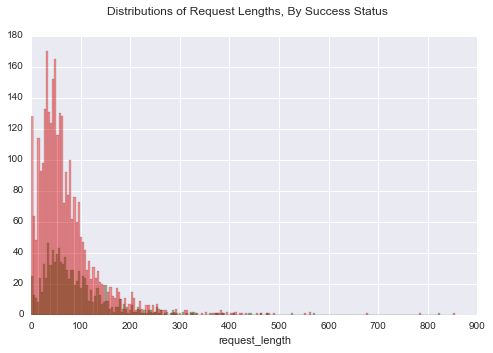

In [192]:
import seaborn as sns
import math

#x = pd.Series(bunny['request_length'], name = 'request granted lenth')
#ax = sns.distplot(x)
sns.set(rc={"figure.figsize": (8, 5)});
fig, ax = plt.subplots()
sns.distplot(bunny['request_length'], ax=ax, color='green',kde=False, rug=False,bins=200)
sns.distplot(jackal['request_length'], ax=ax, color='red',kde=False, rug=False,bins=200)
plt.subplots_adjust(top=0.9)
fig.suptitle('Distributions of Request Lengths, By Success Status')
plt.legend(loc='upper left')
sns.plt.show()

In [202]:
good_words = ['surprise',
              'father',
              'aren',
              'helping',
              'rice',
              'person',
              'sunday',
              'exchange',
              'girl',
              'days',
              'jpg',
              'tight',
              'mentioned',
              'receive',
              'dominos',
              'hurting',
              'unemployed',
              'heat']

In [210]:
#normalize the counts
scl = MaxAbsScaler()
#num_norm = pd.DataFrame(index=num_data.index)
c = 'request_length'
scl.fit(text_data[c].values.reshape(-1,1))
c1 = c+'_scaled'
num_norm[c1] = scl.transform(text_data[c].values.reshape(-1, 1))

In [211]:
num_norm.head()

,requester_account_age_in_days_at_request_scaled,requester_days_since_first_post_on_raop_at_request_scaled,requester_number_of_comments_at_request_scaled,requester_number_of_comments_in_raop_at_request_scaled,requester_number_of_posts_at_request_scaled,requester_number_of_posts_on_raop_at_request_scaled,requester_number_of_subreddits_at_request_scaled,requester_upvotes_minus_downvotes_at_request_scaled,requester_upvotes_plus_downvotes_at_request_scaled,request_length_scaled
0,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.078454
1,0.178347,0.00000,0.000000,0.000000,0.017301,0.0,0.064516,0.000219,0.135831,0.018735
2,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.069087
3,0.002320,0.00000,0.036217,0.000000,0.001153,0.0,0.021505,0.000348,0.088993,0.035129
4,0.057679,0.12936,0.140845,0.022727,0.016148,0.0,0.059140,0.007232,2.029274,0.120609


In [212]:
num_norm.columns

Index(['requester_account_age_in_days_at_request_scaled',
       'requester_days_since_first_post_on_raop_at_request_scaled',
       'requester_number_of_comments_at_request_scaled',
       'requester_number_of_comments_in_raop_at_request_scaled',
       'requester_number_of_posts_at_request_scaled',
       'requester_number_of_posts_on_raop_at_request_scaled',
       'requester_number_of_subreddits_at_request_scaled',
       'requester_upvotes_minus_downvotes_at_request_scaled',
       'requester_upvotes_plus_downvotes_at_request_scaled',
       'request_length_scaled'],
      dtype='object')

In [214]:
#scale down the binarized columsn by the list of best columns
best_cat_cols

['evening',
 'pics',
 'trees',
 'wednesday',
 'Random_Acts_Of_Pizza',
 'gaming',
 'morning',
 'reddit.com']

In [216]:
df6 = df6[best_cat_cols]

In [219]:
#use only the top 20 words for the text data
text_data.head()
tkn_request = TfidfVectorizer(preprocessor=preprocess,stop_words='english',vocabulary=good_words)
#tkn_title = TfidfVectorizer(preprocessor=preprocess,stop_words='english')
feature_request = tkn_request.fit_transform(text_data['request_text_edit_aware'])
#feature_title = tkn_title.fit_transform(data_set['request_title'])

In [226]:
X = hstack((
        csr_matrix(feature_request),
            csr_matrix(df6_data), 
            csr_matrix(num_norm)), 
           format='csr')
y = text_data['requester_received_pizza']

In [227]:
model1 = LogisticRegression()
model1.fit(X, y)
y_pred = model1.predict(X)
print(classification_report(y, y_pred, target_names=target_names))

             precision    recall  f1-score   support

   No pizza       0.87      0.99      0.93      3046
  Got pizza       0.97      0.54      0.69       994

avg / total       0.89      0.88      0.87      4040



In [228]:
sss = StratifiedShuffleSplit(test_size=0.33, random_state=1)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
target_names = [ 'No pizza','Got pizza']
print(classification_report(y_test, y_pred, target_names=target_names))

             precision    recall  f1-score   support

   No pizza       0.77      0.93      0.84      1006
  Got pizza       0.38      0.13      0.20       328

avg / total       0.67      0.73      0.68      1334



In [230]:
#decicsion tree
md = DecisionTreeClassifier()
md.fit(X_train, y_train)
md_pred = md.predict(X_test)
target_names = [ 'No pizza','Got pizza']
print(classification_report(y_test, md_pred, target_names=target_names))

             precision    recall  f1-score   support

   No pizza       0.77      0.79      0.78      1006
  Got pizza       0.29      0.26      0.27       328

avg / total       0.65      0.66      0.65      1334



In [231]:
#random forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
print(classification_report(y_test, rf_pred, target_names=target_names))

             precision    recall  f1-score   support

   No pizza       0.76      0.97      0.85      1006
  Got pizza       0.38      0.05      0.10       328

avg / total       0.66      0.75      0.67      1334



In [232]:
X = hstack((
        #csr_matrix(feature_request),
            csr_matrix(df6_data), 
            csr_matrix(num_norm)), 
           format='csr')

y = text_data['requester_received_pizza']

sss = StratifiedShuffleSplit(test_size=0.33, random_state=1)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
print(classification_report(y_test, rf_pred, target_names=target_names))

             precision    recall  f1-score   support

   No pizza       0.76      0.97      0.85      1006
  Got pizza       0.34      0.05      0.09       328

avg / total       0.66      0.74      0.66      1334



In [235]:
from sklearn.ensemble import ExtraTreesClassifier
X = hstack((
        csr_matrix(feature_request),
            csr_matrix(df6_data), 
            csr_matrix(num_norm)), 
           format='csr')

y = text_data['requester_received_pizza']

sss = StratifiedShuffleSplit(test_size=0.33, random_state=1)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
et = ExtraTreesClassifier()
et.fit(X_train, y_train)
et_pred = et.predict(X_test)
print(classification_report(y_test, et_pred, target_names=target_names))

             precision    recall  f1-score   support

   No pizza       0.76      0.96      0.85      1006
  Got pizza       0.40      0.08      0.13       328

avg / total       0.67      0.74      0.67      1334



In [236]:
from sklearn.ensemble import ExtraTreesClassifier
X = hstack((
        #csr_matrix(feature_request),
            csr_matrix(df6_data), 
            csr_matrix(num_norm)), 
           format='csr')

y = text_data['requester_received_pizza']

sss = StratifiedShuffleSplit(test_size=0.33, random_state=1)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
et1 = ExtraTreesClassifier()
et1.fit(X_train, y_train)
et1_pred = et1.predict(X_test)
print(classification_report(y_test, et1_pred, target_names=target_names))

             precision    recall  f1-score   support

   No pizza       0.75      0.95      0.84      1006
  Got pizza       0.23      0.05      0.08       328

avg / total       0.62      0.73      0.65      1334



### Ada Boost

The module sklearn.ensemble includes the popular boosting algorithm AdaBoost, introduced in 1995 by Freund and Schapire [FS1995].

The core principle of AdaBoost is to fit a sequence of weak learners (i.e., models that are only slightly better than random guessing, such as small decision trees) on repeatedly modified versions of the data. The predictions from all of them are then combined through a weighted majority vote (or sum) to produce the final prediction. The data modifications at each so-called boosting iteration consist of applying weights w_1, w_2, ..., w_N to each of the training samples. Initially, those weights are all set to w_i = 1/N, so that the first step simply trains a weak learner on the original data. For each successive iteration, the sample weights are individually modified and the learning algorithm is reapplied to the reweighted data. At a given step, those training examples that were incorrectly predicted by the boosted model induced at the previous step have their weights increased, whereas the weights are decreased for those that were predicted correctly. As iterations proceed, examples that are difficult to predict receive ever-increasing influence. Each subsequent weak learner is thereby forced to concentrate on the examples that are missed by the previous ones in the sequence [HTF].

In [237]:
#adaboost


from sklearn.ensemble import AdaBoostClassifier
X = hstack((
        csr_matrix(feature_request),
            csr_matrix(df6_data), 
            csr_matrix(num_norm)), 
           format='csr')

y = text_data['requester_received_pizza']

sss = StratifiedShuffleSplit(test_size=0.33, random_state=1)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
ad = AdaBoostClassifier()
ad.fit(X_train, y_train)
ad_pred = ad.predict(X_test)
print(classification_report(y_test, ad_pred, target_names=target_names))

             precision    recall  f1-score   support

   No pizza       0.77      0.95      0.85      1006
  Got pizza       0.42      0.12      0.19       328

avg / total       0.68      0.74      0.68      1334



In [238]:
#adaboost
from sklearn.ensemble import AdaBoostClassifier
X = hstack((
        #csr_matrix(feature_request),
            csr_matrix(df6_data), 
            csr_matrix(num_norm)), 
           format='csr')

y = text_data['requester_received_pizza']

sss = StratifiedShuffleSplit(test_size=0.33, random_state=1)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
ad1 = AdaBoostClassifier()
ad1.fit(X_train, y_train)
ad1_pred = ad1.predict(X_test)
print(classification_report(y_test, ad1_pred, target_names=target_names))

             precision    recall  f1-score   support

   No pizza       0.76      0.95      0.84      1006
  Got pizza       0.34      0.08      0.12       328

avg / total       0.66      0.74      0.67      1334



In [241]:
from sklearn.ensemble import GradientBoostingClassifier

X = hstack((
        csr_matrix(feature_request),
            csr_matrix(df6_data), 
            csr_matrix(num_norm)), 
           format='csr')
X = X.toarray()
y = text_data['requester_received_pizza']

sss = StratifiedShuffleSplit(test_size=0.33, random_state=1)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
grb = GradientBoostingClassifier()
grb.fit(X_train, y_train)
grb_pred = grb.predict(X_test)
print(classification_report(y_test, grb_pred, target_names=target_names))

             precision    recall  f1-score   support

   No pizza       0.76      0.98      0.86      1006
  Got pizza       0.52      0.07      0.12       328

avg / total       0.70      0.76      0.68      1334



In [303]:
### Adaboost with the top request terms did the best, let's check how it does with the 
### whole request document and title

tkn_request = TfidfVectorizer(preprocessor=preprocess,stop_words='english')
tkn_title = TfidfVectorizer(preprocessor=preprocess,stop_words='english')
feature_request = tkn_request.fit_transform(text_data['request_text_edit_aware'])
feature_title = tkn_title.fit_transform(data_set['request_title'])


from sklearn.ensemble import AdaBoostClassifier
X = hstack((
        csr_matrix(feature_request),
        #csr_matrix(feature2_title),
        csr_matrix(df6), 
        csr_matrix(num_norm)), 
        format='csr')

y = text_data['requester_received_pizza']

sss = StratifiedShuffleSplit(test_size=0.33, random_state=1)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
ad2 = AdaBoostClassifier()
ad2.fit(X_train, y_train)
ad2_pred = ad2.predict(X_test)
print(classification_report(y_test, ad2_pred, target_names=target_names))


             precision    recall  f1-score   support

   No pizza       0.77      0.93      0.84      1006
  Got pizza       0.41      0.15      0.22       328

avg / total       0.68      0.74      0.69      1334



In [304]:
# adaboost does best with the whole request, no title, and the parsed down df6 data and 
# num_norm.  Let's see how it does with the test data

# categorical
tstdf6 = tstdf6[best_cat_cols]
# numeric
tstdf['request_length'] = tstdf['request_text_edit_aware'].map(lambda x: len(x.split()))
c = 'request_length'
scl.fit(tstdf[c].values.reshape(-1,1))
c1 = c+'_scaled'
num_norm_test[c1] = scl.transform(tstdf[c].values.reshape(-1, 1))
# text data
tfeature_request = tkn_request.transform(tstdf['request_text_edit_aware'])

Xt = hstack((
        csr_matrix(tfeature_request),
        csr_matrix(tstdf6), 
        csr_matrix(num_norm_test)), 
        format='csr')

#X_test = pd.concat([], axis =1)


Y_pred = ad2.predict(Xt)


In [307]:
def inter(x):
    return int(x)
vint = np.vectorize(inter)
Y_pred_2 = vint(Y_pred)
fin_df = pd.concat([test['request_id'],pd.DataFrame(Y_pred_2, columns=['requester_received_pizza'])],axis =1)
fin_df['requester_received_pizza'] = pd.to_numeric(fin_df['requester_received_pizza'],downcast='signed')
fin_df.head()

,request_id,requester_received_pizza
0,t3_i8iy4,0
1,t3_1mfqi0,0
2,t3_lclka,0
3,t3_1jdgdj,0
4,t3_t2qt4,0


In [308]:
fin_df.to_csv('pizza_submission7.csv', sep = ',', index=False, header=True)

In [322]:
### we got a better result when we used all the categorical features by 1 percent
### Adaboost with the top request terms did the best, let's check how it does with the 
### whole request document and title
### this was the best kaggle score model
tkn_request = TfidfVectorizer(preprocessor=preprocess,stop_words='english')
tkn_title = TfidfVectorizer(preprocessor=preprocess,stop_words='english')
feature_request = tkn_request.fit_transform(text_data['request_text_edit_aware'])
feature_title = tkn_title.fit_transform(data_set['request_title'])


from sklearn.ensemble import AdaBoostClassifier
X = hstack((
        csr_matrix(feature_request),
        csr_matrix(feature_title),
        csr_matrix(df6_data), 
        csr_matrix(num_norm)), 
        format='csr')

y = text_data['requester_received_pizza']

sss = StratifiedShuffleSplit(test_size=0.20, random_state=1)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
ad2 = AdaBoostClassifier()
ad2.fit(X_train, y_train)
ad2_pred = ad2.predict(X_test)
print(classification_report(y_test, ad2_pred, target_names=target_names))


             precision    recall  f1-score   support

   No pizza       0.78      0.95      0.86       609
  Got pizza       0.52      0.17      0.26       199

avg / total       0.72      0.76      0.71       808



In [317]:
#tstdf6 = pd.read_json('binarized_categorical_test_data.json')
#del tstdf6['request_id']
#tstdf6 = tstdf6[df6_data.columns]


In [318]:
np.average(Y_pred)

0.09012875536480687

In [320]:
def inter(x):
    return int(x)
vint = np.vectorize(inter)
Y_pred_2 = vint(Y_pred)
fin_df = pd.concat([test['request_id'],pd.DataFrame(Y_pred_2, columns=['requester_received_pizza'])],axis =1)
fin_df['requester_received_pizza'] = pd.to_numeric(fin_df['requester_received_pizza'],downcast='signed')
fin_df.head()

,request_id,requester_received_pizza
0,t3_i8iy4,0
1,t3_1mfqi0,0
2,t3_lclka,0
3,t3_1jdgdj,0
4,t3_t2qt4,0


In [321]:
fin_df.to_csv('pizza_submission8.csv', sep = ',', index=False, header=True)

In [294]:
num_norm_test.shape

(1631, 10)

In [324]:
tfeature_title = tkn_title.transform(tstdf['request_text_edit_aware'])

Xt = hstack((
        csr_matrix(tfeature_request),
        csr_matrix(tfeature_title),
        csr_matrix(ntstdf6), 
        csr_matrix(num_norm_test)), 
        format='csr')

#X_test = pd.concat([], axis =1)


Y_pred = ad2.predict(Xt)

In [325]:
np.average(Y_pred)

0.074187614960147155

In [326]:
Y_pred_2 = vint(Y_pred)
fin_df = pd.concat([test['request_id'],pd.DataFrame(Y_pred_2, columns=['requester_received_pizza'])],axis =1)
fin_df['requester_received_pizza'] = pd.to_numeric(fin_df['requester_received_pizza'],downcast='signed')
fin_df.head()

,request_id,requester_received_pizza
0,t3_i8iy4,0
1,t3_1mfqi0,0
2,t3_lclka,0
3,t3_1jdgdj,0
4,t3_t2qt4,0


In [327]:
fin_df.to_csv('pizza_submission9.csv', sep = ',', index=False, header=True)

In [338]:
### we got a better result when we used all the categorical features by 1 percent
### Adaboost with the top request terms did the best, let's check how it does with the 
### whole request document and title

tkn_request = TfidfVectorizer(preprocessor=preprocess,stop_words='english',vocabulary=good_words)
tkn_title = TfidfVectorizer(preprocessor=preprocess,stop_words='english')
feature_request = tkn_request.fit_transform(text_data['request_text_edit_aware'])
feature_title = tkn_title.fit_transform(text_data['request_title'])


from sklearn.ensemble import AdaBoostClassifier
X = hstack((
        csr_matrix(feature_request),
        csr_matrix(feature_title),
        csr_matrix(df6_data), 
        csr_matrix(num_norm)), 
        format='csr')

y = text_data['requester_received_pizza']

sss = StratifiedShuffleSplit(test_size=
                             0.20, random_state=1)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
ad2 = AdaBoostClassifier()
ad2.fit(X_train, y_train)
ad2_pred = ad2.predict(X_test)
print(classification_report(y_test, ad2_pred, target_names=target_names))


             precision    recall  f1-score   support

   No pizza       0.78      0.96      0.86       609
  Got pizza       0.58      0.19      0.28       199

avg / total       0.73      0.77      0.72       808



In [332]:
tfeature_request = tkn_request.transform(tstdf['request_text_edit_aware']) 
tfeature_title = tkn_title.transform(tstdf['request_title'])

Xt = hstack((
        csr_matrix(tfeature_request),
        csr_matrix(tfeature_title),
        csr_matrix(ntstdf6), 
        csr_matrix(num_norm_test)), 
        format='csr')

#X_test = pd.concat([], axis =1)


Y_pred = ad2.predict(Xt)

In [333]:
np.average(Y_pred)

0.083997547516860824

In [334]:
Y_pred_2 = vint(Y_pred)
fin_df = pd.concat([test['request_id'],pd.DataFrame(Y_pred_2, columns=['requester_received_pizza'])],axis =1)
fin_df['requester_received_pizza'] = pd.to_numeric(fin_df['requester_received_pizza'],downcast='signed')
fin_df.head()

,request_id,requester_received_pizza
0,t3_i8iy4,0
1,t3_1mfqi0,0
2,t3_lclka,0
3,t3_1jdgdj,0
4,t3_t2qt4,0


In [336]:
fin_df.to_csv('pizza_submission10.csv', sep = ',', index=False, header=True)